In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import time
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [ ]:
from google.colab import files
import zipfile
uploaded = files.upload()  # pick your zip

zip_path = list(uploaded.keys())[0]
extract_dir = "/content/data"
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_dir)
print("Extracted to", extract_dir)

Saving keras_png_slices_data.zip to keras_png_slices_data.zip
Extracted to /content/data


In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if not torch.cuda.is_available():
    print("Warning CUDA not Found. Using CPU")

# Hyper-parameters
num_epochs = 8
learning_rate = 1e-3

In [ ]:
class MRIDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith(".png")]
        self.transform = transform

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        image = Image.open(img_path).convert("L")  # grayscale
        if self.transform:
            image = self.transform(image)
        return image, 0 # Return image and a dummy label
# Define preprocessing
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Example usage: replace with your train/val/test folders
train_dir = "/content/data/keras_png_slices_data/keras_png_slices_train"
val_dir   = "/content/data/keras_png_slices_data/keras_png_slices_validate"
test_dir  = "/content/data/keras_png_slices_data/keras_png_slices_test"

trainset = MRIDataset(train_dir, transform=transform)
valset   = MRIDataset(val_dir, transform=transform)
testset  = MRIDataset(test_dir, transform=transform)

train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
val_loader   = DataLoader(valset, batch_size=64, shuffle=False)
test_loader  = DataLoader(testset, batch_size=64, shuffle=False)

print(f"Train: {len(trainset)}, Val: {len(valset)}, Test: {len(testset)}")

Train: 9664, Val: 1120, Test: 544


In [ ]:
class CNNVAE(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder (same as before but outputs mean and log_var)
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # 128x128 -> 128x128
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 128x128 -> 64x64

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 64x64 -> 64x64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 64x64 -> 32x32

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # 32x32 -> 32x32
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32x32 -> 16x16

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), # 16x16 -> 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2), # 16x16 -> 8x8

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), # 8x8 -> 8x8
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2), # 8x8 -> 4x4

            nn.Flatten(),
        )

        # Latent space parameters
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)      # Mean
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)  # Log variance

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (128, 4, 4)),  # Reshape to (batch, 128, 4, 4)

            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1), # 4x4 -> 8x8
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.2),

            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1), # 8x8 -> 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.2),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16x16 -> 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.2),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32x32 -> 64x64
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.2),

            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 64x64 -> 128x128
            nn.Sigmoid()  # Output in [0, 1] for image reconstruction
        )


    def encode(self, x):
        """Encode input to latent parameters"""
        h = self.encoder_conv(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """Reparameterization trick: sample from N(mu, var) using N(0,1)"""
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu  # Use mean for inference. Using mu (mean) rather than sampling from the full distribution because:
                        # It provides deterministic, reproducible results
                        # The mean represents the "most likely" latent representation
                        # It avoids noise that could make interpolation less smooth

    def decode(self, z):
        """Decode latent variable to reconstruction"""
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

def vae_loss_function(recon_x, x, mu, logvar, beta=1.0):
    """
    VAE loss = Reconstruction loss + KL divergence
    beta: weight for KL divergence (beta-VAE)
    """
    # Reconstruction loss (Binary Cross Entropy)
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL divergence loss
    # KLD = -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + beta * KLD, BCE, KLD

Training VAE...
VAE Epoch [1/10], Loss: 6428.3621, BCE: 6397.1869, KLD: 31.1752


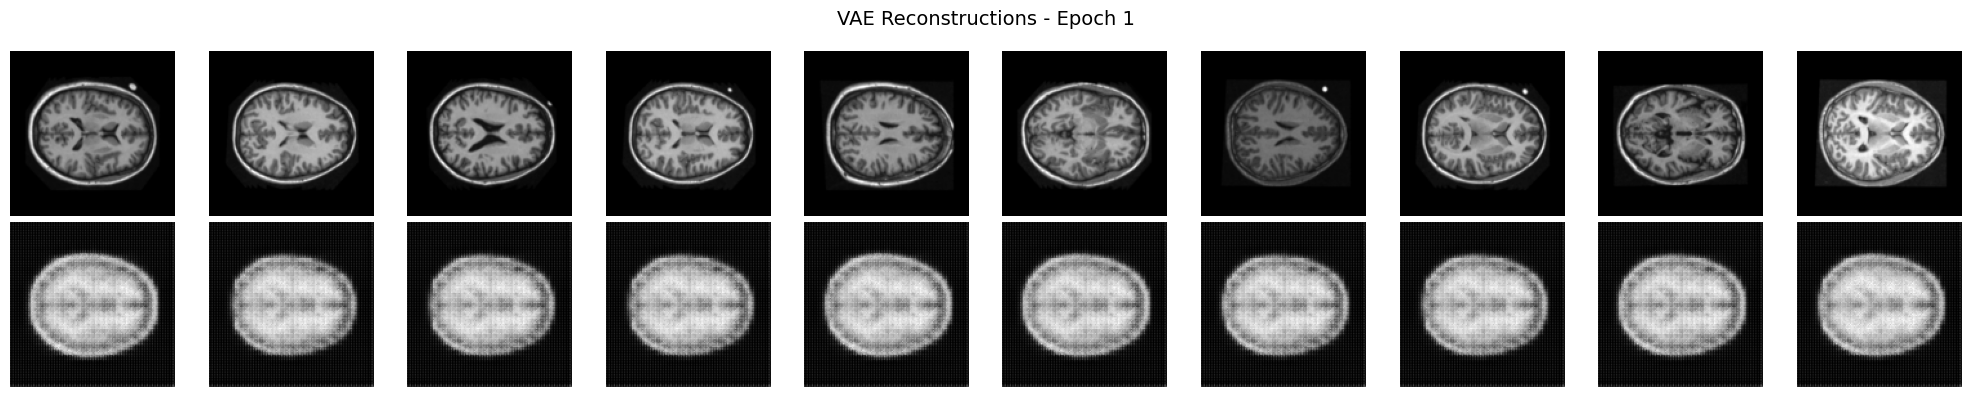

VAE Epoch [2/10], Loss: 4535.4136, BCE: 4515.5783, KLD: 19.8354


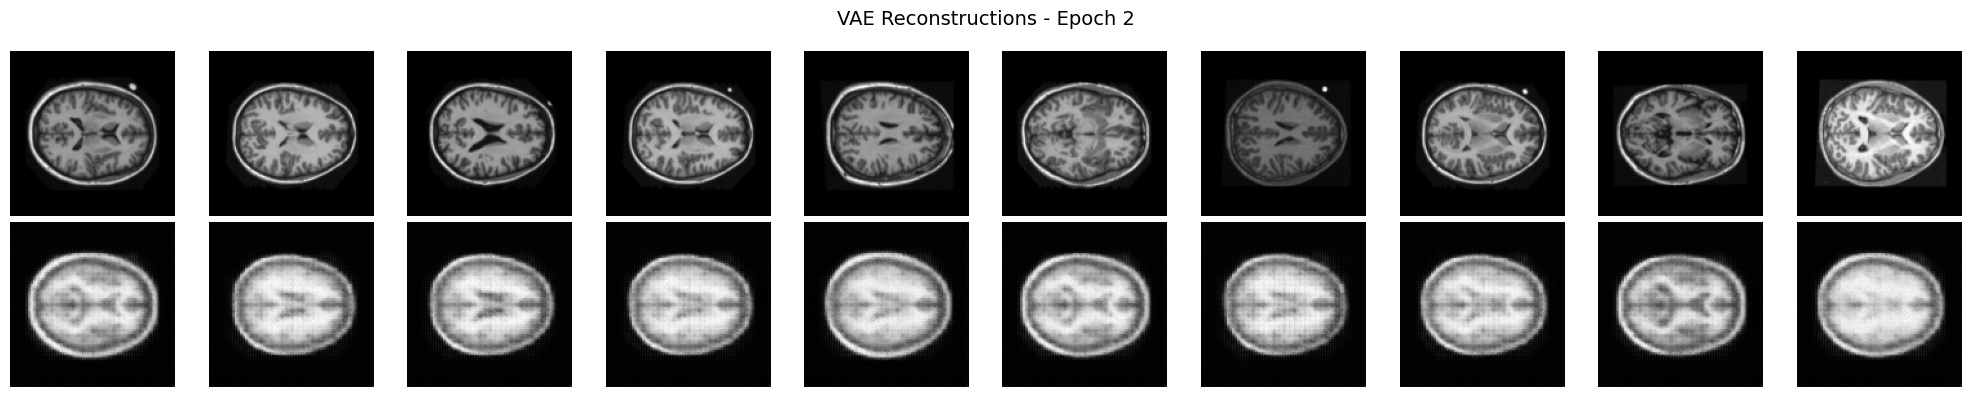

VAE Epoch [3/10], Loss: 4358.2741, BCE: 4338.1829, KLD: 20.0913


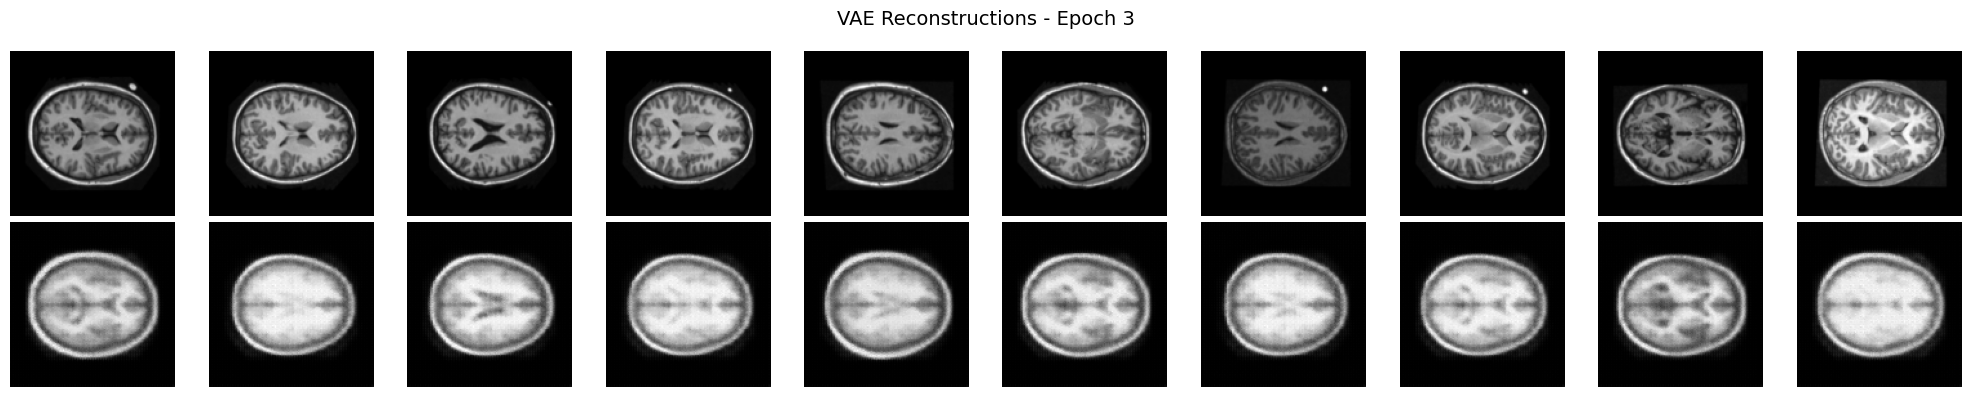

VAE Epoch [4/10], Loss: 4294.5588, BCE: 4273.1648, KLD: 21.3940


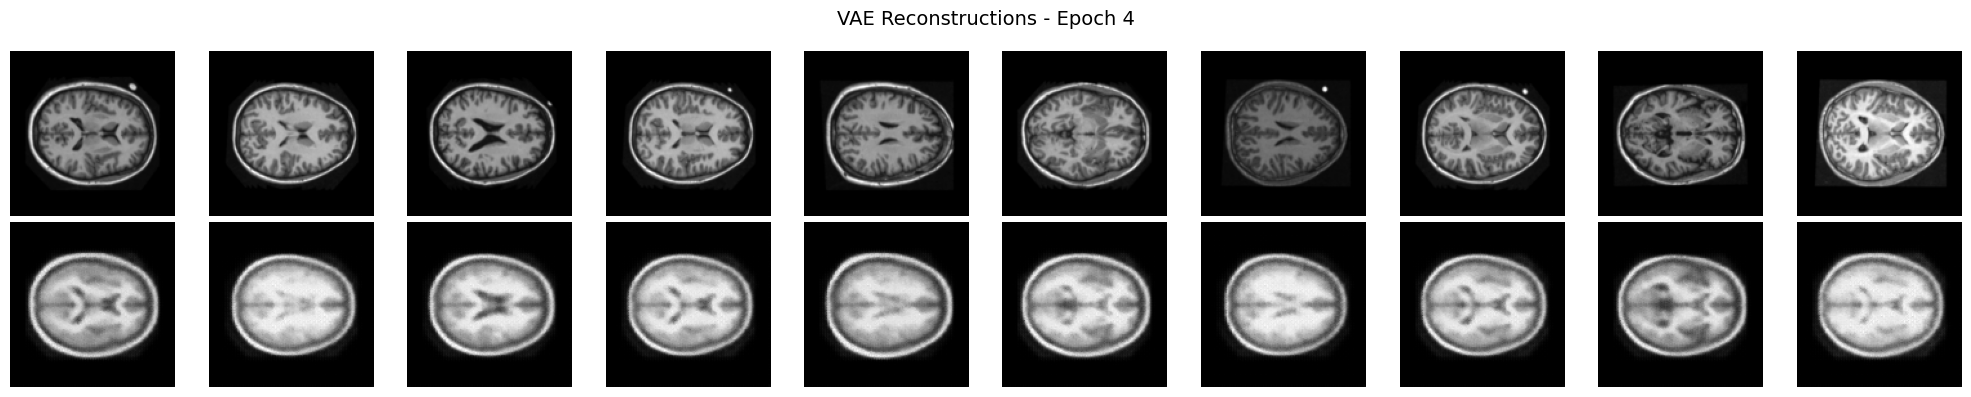

VAE Epoch [5/10], Loss: 4259.8040, BCE: 4237.8470, KLD: 21.9571


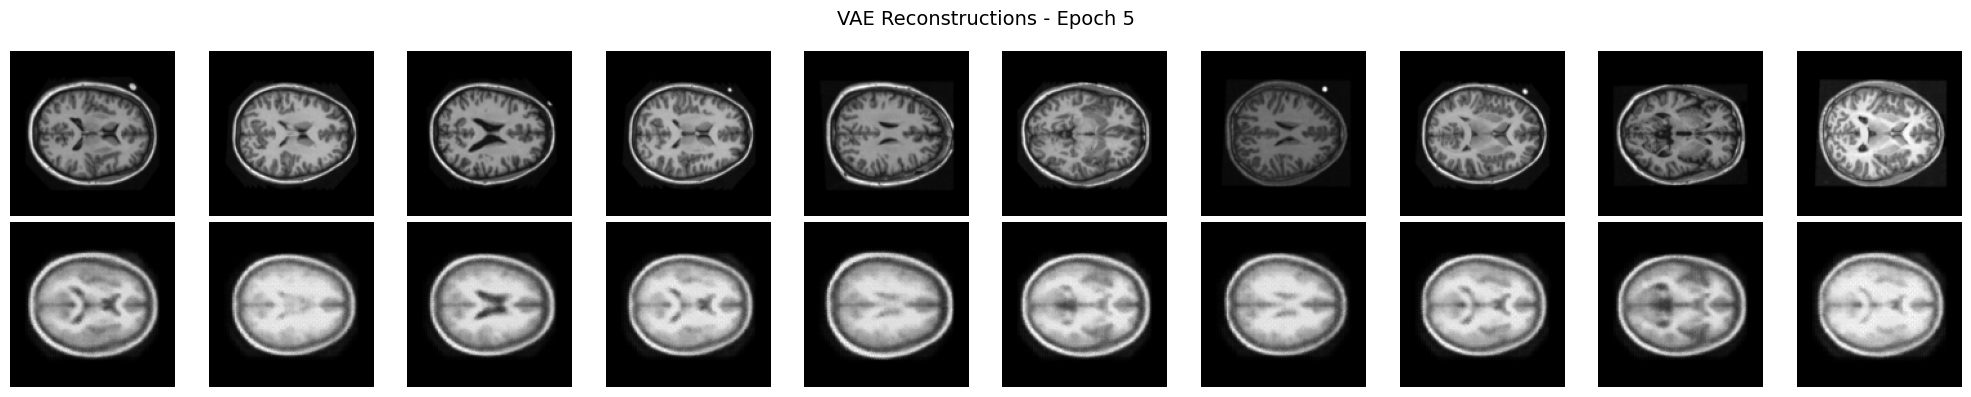

VAE Epoch [6/10], Loss: 4235.6308, BCE: 4214.2160, KLD: 21.4148


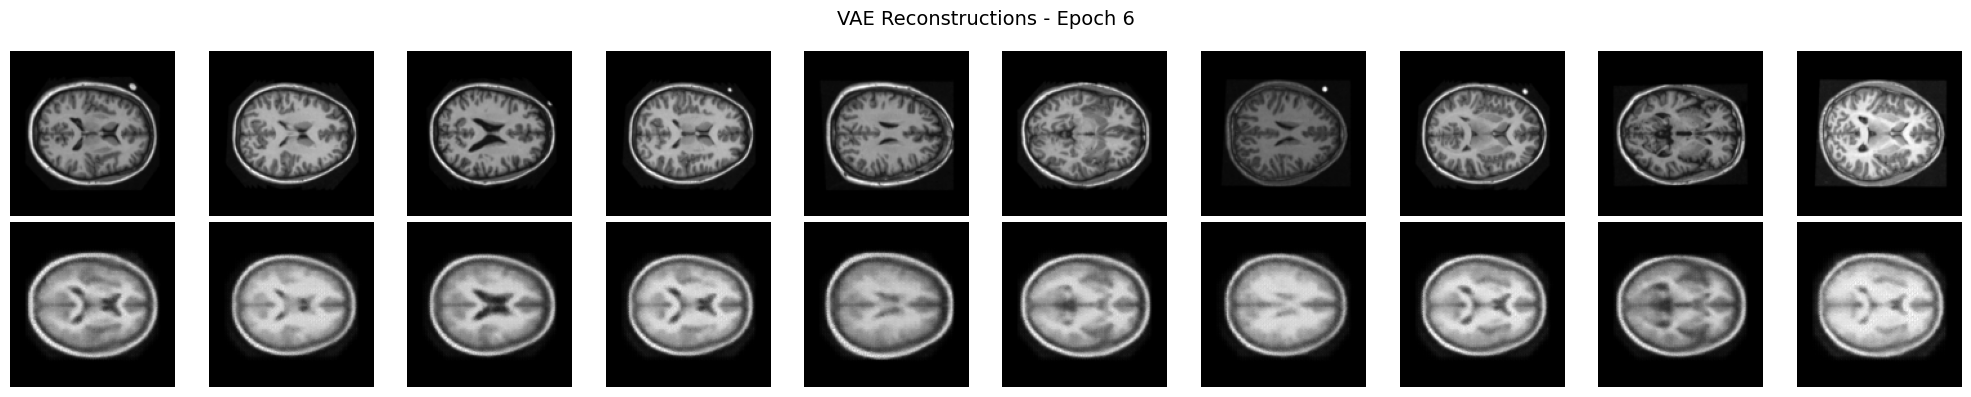

VAE Epoch [7/10], Loss: 4220.1147, BCE: 4198.5519, KLD: 21.5628


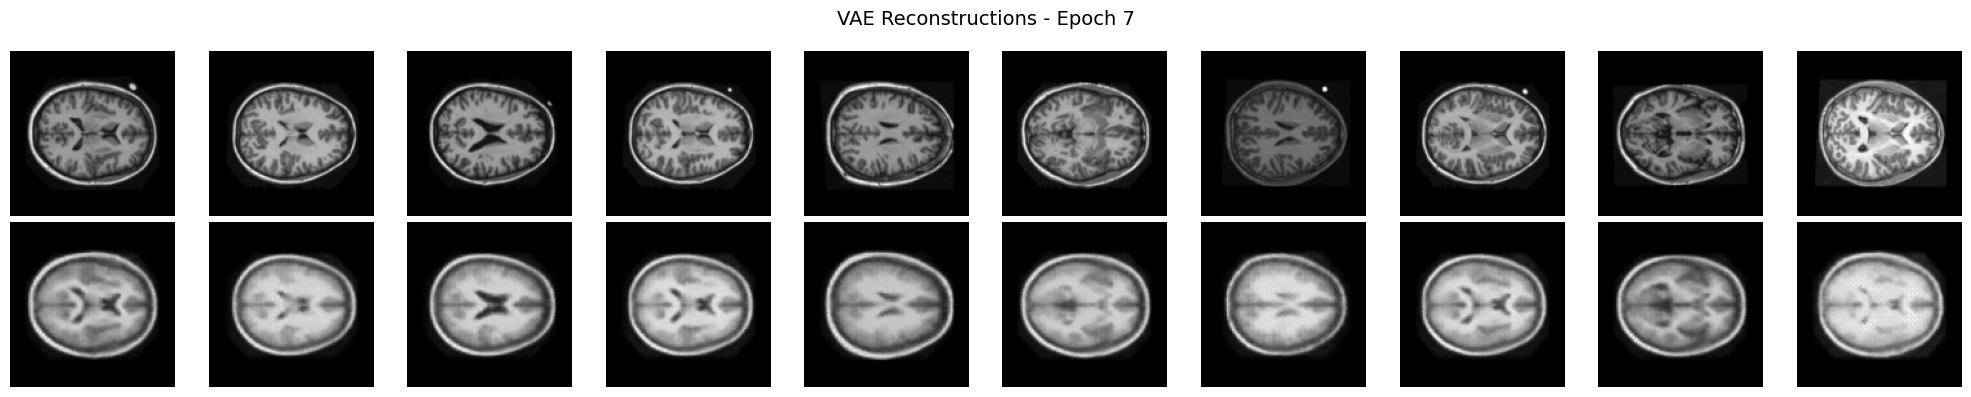

VAE Epoch [8/10], Loss: 4207.6693, BCE: 4186.2638, KLD: 21.4055


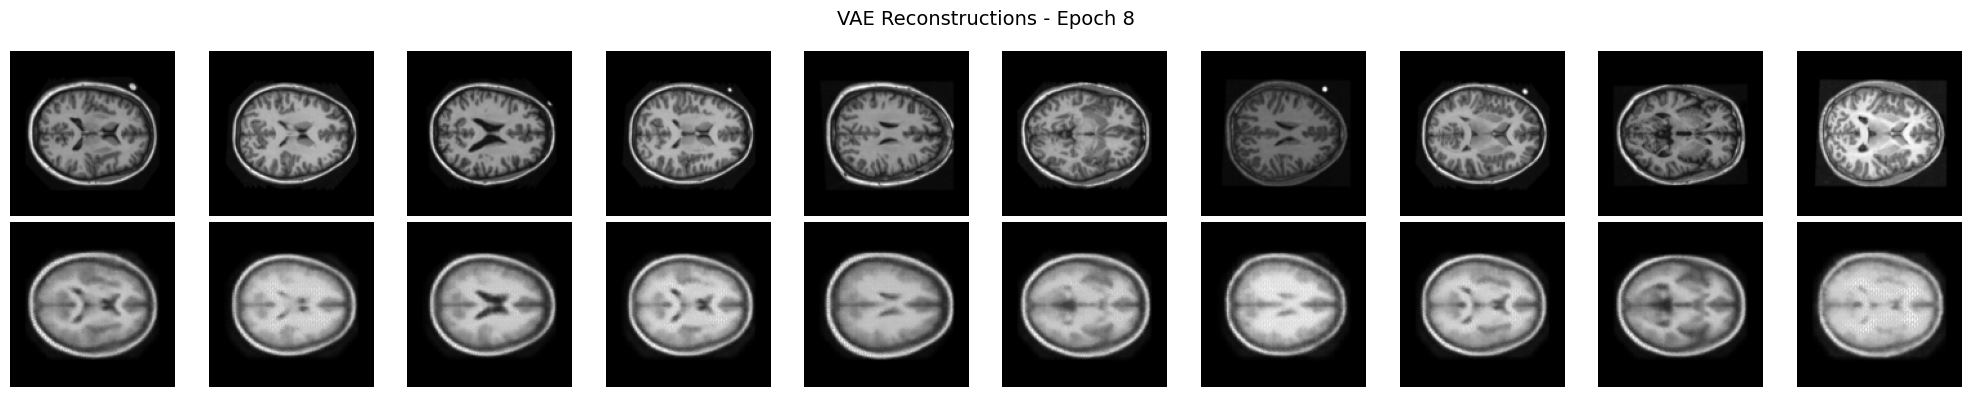

VAE Epoch [9/10], Loss: 4197.5807, BCE: 4176.0839, KLD: 21.4968


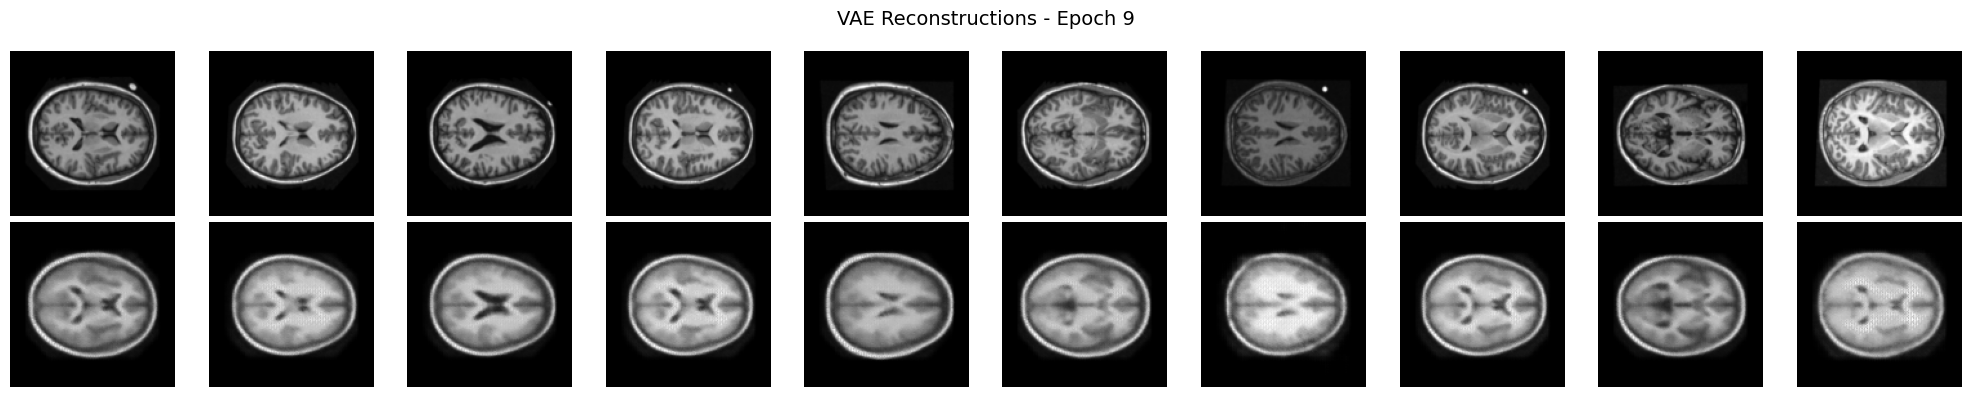

VAE Epoch [10/10], Loss: 4189.3196, BCE: 4168.0276, KLD: 21.2920


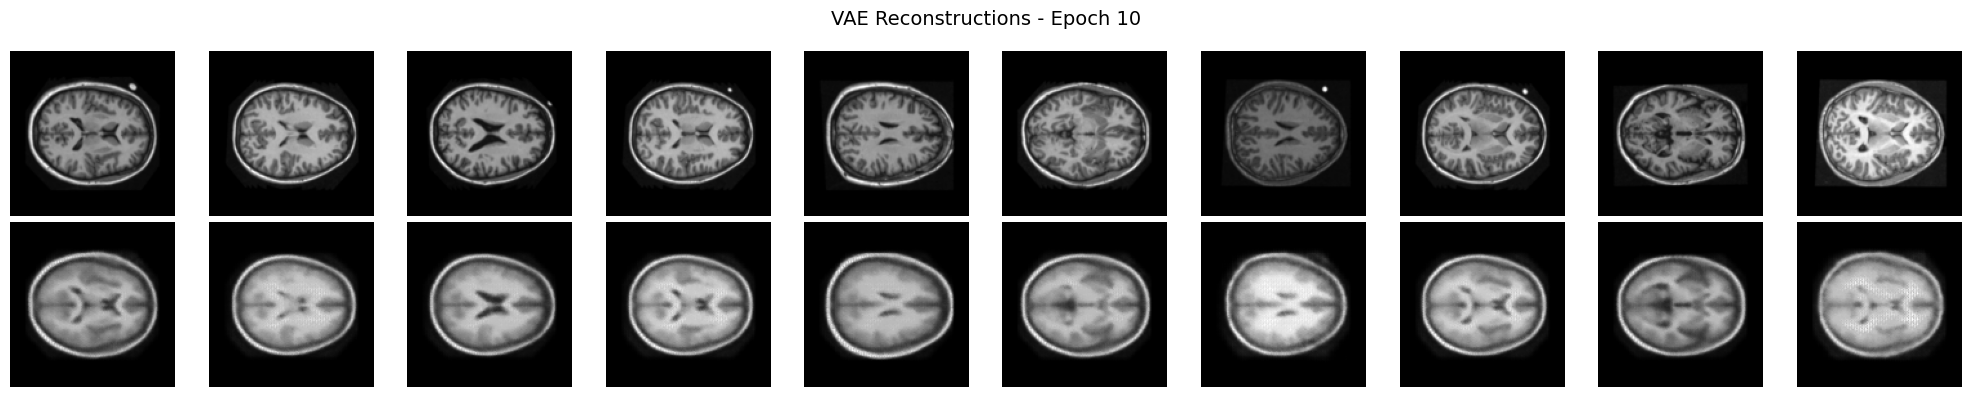

In [ ]:
import matplotlib.pyplot as plt
# Train the VAE
vae = CNNVAE(latent_dim=32).to(device)
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

# Training loop
num_vae_epochs = 10
beta = 1.0  # Beta parameter for beta-VAE (1.0 = standard VAE)

print("Training VAE...")
for epoch in range(num_vae_epochs):
    vae.train()
    total_loss = 0
    total_bce = 0
    total_kld = 0

    for batch_idx, (images, _) in enumerate(train_loader):
        images = images.to(device)

        # Forward pass
        recon_images, mu, logvar = vae(images)

        # Calculate loss
        loss, bce, kld = vae_loss_function(recon_images, images, mu, logvar, beta)

        # Backward pass
        vae_optimizer.zero_grad()
        loss.backward()
        vae_optimizer.step()

        total_loss += loss.item()
        total_bce += bce.item()
        total_kld += kld.item()

    avg_loss = total_loss / len(train_loader.dataset)
    avg_bce = total_bce / len(train_loader.dataset)
    avg_kld = total_kld / len(train_loader.dataset)

    print(f'VAE Epoch [{epoch+1}/{num_vae_epochs}], Loss: {avg_loss:.4f}, BCE: {avg_bce:.4f}, KLD: {avg_kld:.4f}')

    # Visualize reconstructions every few epochs
    if (epoch + 1) % 1 == 0 or epoch == 0:
        vae.eval()
        with torch.no_grad():
            test_images, _ = next(iter(test_loader))
            test_images = test_images.to(device)
            recon_images, _, _ = vae(test_images)

            # Plot original vs reconstructed
            fig, axes = plt.subplots(2, 10, figsize=(20, 4))
            for i in range(10):
                # Original
                axes[0, i].imshow(test_images[i].cpu().squeeze(), cmap='gray')
                axes[0, i].axis('off')
                if i == 0:
                    axes[0, i].set_ylabel('Original', fontsize=12)

                # Reconstructed
                axes[1, i].imshow(recon_images[i].cpu().squeeze(), cmap='gray')
                axes[1, i].axis('off')
                if i == 0:
                    axes[1, i].set_ylabel('Reconstructed', fontsize=12)

            plt.suptitle(f'VAE Reconstructions - Epoch {epoch+1}', fontsize=14)
            plt.tight_layout()
            plt.show()

Creating 2D manifold of MRI...
Using latent dimensions 9 and 12 for manifold


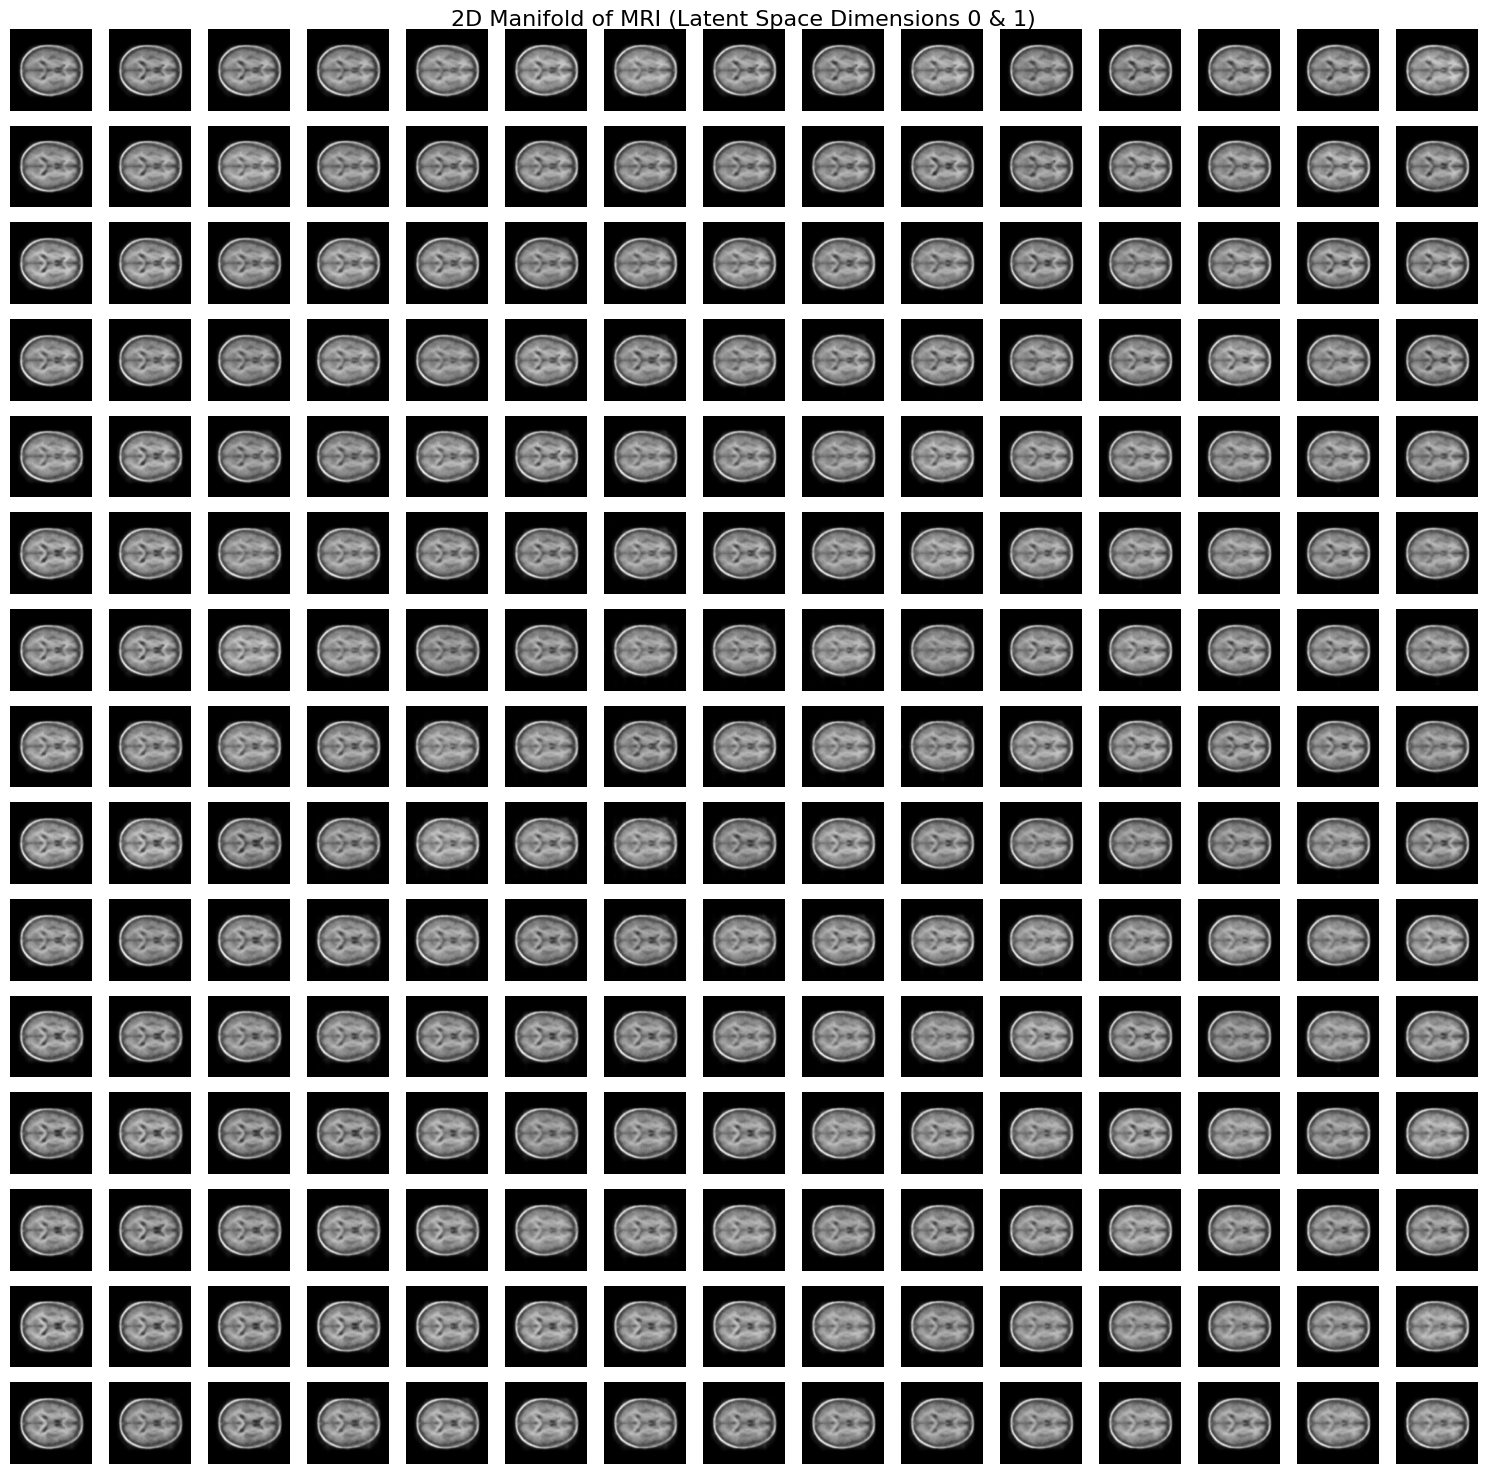

In [ ]:
# Create a 2D manifold visualization of digits
print("Creating 2D manifold of MRI...")

def plot_digit_manifold(vae, n_grid=15, figsize=(15, 15)):
    """
    Plot a 2D manifold of digits by sampling from a grid in latent space
    """
    vae.eval()

    # Create a grid of points in 2D latent space
    # We'll use the first 2 dimensions of the latent space
    grid_x = np.linspace(-3, 3, n_grid)
    grid_y = np.linspace(-3, 3, n_grid)

    fig, axes = plt.subplots(n_grid, n_grid, figsize=figsize)

    # Randomly select which 2 dimensions to use for the manifold
    dim1 = np.random.randint(0, vae.latent_dim)
    dim2 = np.random.randint(0, vae.latent_dim)
    while dim2 == dim1:
        dim2 = np.random.randint(0, vae.latent_dim)

    print(f"Using latent dimensions {dim1} and {dim2} for manifold")

    with torch.no_grad():
        for i, y in enumerate(grid_y):
            for j, x in enumerate(grid_x):
                # Create latent vector with small random noise in other dimensions
                z = torch.randn(1, vae.latent_dim).to(device) * 0.1  # Small noise
                z[0, dim1] = x
                z[0, dim2] = y

                # Decode the latent vector
                decoded_img = vae.decode(z)

                # Plot the decoded image
                axes[i, j].imshow(decoded_img.cpu().squeeze(), cmap='gray')
                axes[i, j].axis('off')

    plt.suptitle('2D Manifold of MRI (Latent Space Dimensions 0 & 1)', fontsize=16)
    plt.tight_layout()
    plt.show()

# Import numpy if not already imported
import numpy as np

# Create the manifold visualization
plot_digit_manifold(vae, n_grid=15)